# Capstone 3
## Deep Learning for Amazon Rainforest Monitoring
### Data Wrangling & EDA

In [1]:
from pathlib import Path
import zipfile
import os
import shutil

import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import matplotlib.image as mpimg

import warnings
warnings.filterwarnings('ignore')

Firstly, I began the data collection by accessing the Kaggle API, using my personal credentials to ensure secure retrieval:

In [2]:
#!pip install kaggle
#! mkdir -p ~/.kaggle/
#! mv kaggle.json ~/.kaggle/
#!kaggle competitions download -c 'planet-understanding-the-amazon-from-space'

The dataset is in a compressed zip format. To extract its contents, I used the following code:

In [3]:
zip_path = 'planet-understanding-the-amazon-from-space.zip'
extract_to = 'data'

if not os.path.exists(extract_to):
    os.makedirs(extract_to)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f'Contents extracted to {extract_to}')

Contents extracted to data


In [4]:
path = Path('/Users/daiannestarr/Desktop/Springboard/Capstone3/data')

contents = path.iterdir()
for item in contents:
    print(item)

/Users/daiannestarr/Desktop/Springboard/Capstone3/data/planet
/Users/daiannestarr/Desktop/Springboard/Capstone3/data/planets-dataset.zip
/Users/daiannestarr/Desktop/Springboard/Capstone3/data/sample_submission_v2.csv
/Users/daiannestarr/Desktop/Springboard/Capstone3/data/test_v2_file_mapping.csv
/Users/daiannestarr/Desktop/Springboard/Capstone3/data/train_v2.csv
/Users/daiannestarr/Desktop/Springboard/Capstone3/data/test-jpg-additional
/Users/daiannestarr/Desktop/Springboard/Capstone3/data/Kaggle-planet-test-tif.torrent
/Users/daiannestarr/Desktop/Springboard/Capstone3/data/Kaggle-planet-train-tif.torrent


Turns out, the dataset came with only torrent files, not the images I was expecting. 

I attempted to download the images through a web-based torrent client, but the sheer size of the files — 19GB and 13GB — meant it would take a considerable amount of time. 

After some research, I discovered that someone had re-uploaded the images directly on Kaggle:

In [5]:
!kaggle datasets download nikitarom/planets-dataset -p "{path}"
!unzip -q -n '{path}'/planets-dataset.zip -d '{path}'

planets-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
path = Path('/Users/daiannestarr/Desktop/Springboard/Capstone3/kaggle/planet/planet')

contents = path.iterdir()
for item in contents:
    print(item)

/Users/daiannestarr/Desktop/Springboard/Capstone3/kaggle/planet/planet/.DS_Store
/Users/daiannestarr/Desktop/Springboard/Capstone3/kaggle/planet/planet/train_classes.csv
/Users/daiannestarr/Desktop/Springboard/Capstone3/kaggle/planet/planet/test-jpg
/Users/daiannestarr/Desktop/Springboard/Capstone3/kaggle/planet/planet/sample_submission.csv
/Users/daiannestarr/Desktop/Springboard/Capstone3/kaggle/planet/planet/train-jpg


Great! The images were sucessfully downloaded!

---

## Data Exploration

In [7]:
test_file_mapping = pd.read_csv('kaggle/planet/planet/sample_submission.csv')
train_labels = pd.read_csv('kaggle/planet/planet/train_classes.csv')

print(test_file_mapping.head())
print(train_labels.head())

  image_name                                  tags
0     test_0  primary clear agriculture road water
1     test_1  primary clear agriculture road water
2     test_2  primary clear agriculture road water
3     test_3  primary clear agriculture road water
4     test_4  primary clear agriculture road water
  image_name                                       tags
0    train_0                               haze primary
1    train_1            agriculture clear primary water
2    train_2                              clear primary
3    train_3                              clear primary
4    train_4  agriculture clear habitation primary road


In both datasets, each image is associated with multiple labels  within the variable 'tags'. 

The variable 'tags' represent different classifications of the images, illustrating the multi-label nature of the dataset.

In [8]:
#check for null values
print(train_labels.isnull().sum())

image_name    0
tags          0
dtype: int64


In [9]:
tag_counts = train_labels['tags'].value_counts()
print(tag_counts.info())
print(tag_counts.describe())

<class 'pandas.core.series.Series'>
Index: 449 entries, clear primary to agriculture partly_cloudy primary road conventional_mine
Series name: tags
Non-Null Count  Dtype
--------------  -----
449 non-null    int64
dtypes: int64(1)
memory usage: 7.0+ KB
None
count      449.000000
mean        90.153675
std        695.896878
min          1.000000
25%          1.000000
50%          3.000000
75%         12.000000
max      13636.000000
Name: tags, dtype: float64


* The total number of unique tag combinations is 449.
* On average, a unique tag combination appears about 90 times in the dataset.
* However, the distribution is highly skewed, as indicated by the large standard deviation (~696).
* The median frequency of a tag combination is 3 times, with 25% of the tag combinations appearing only once.
* The most frequent tag combination is 'clear primary', which appears 13,636 times.

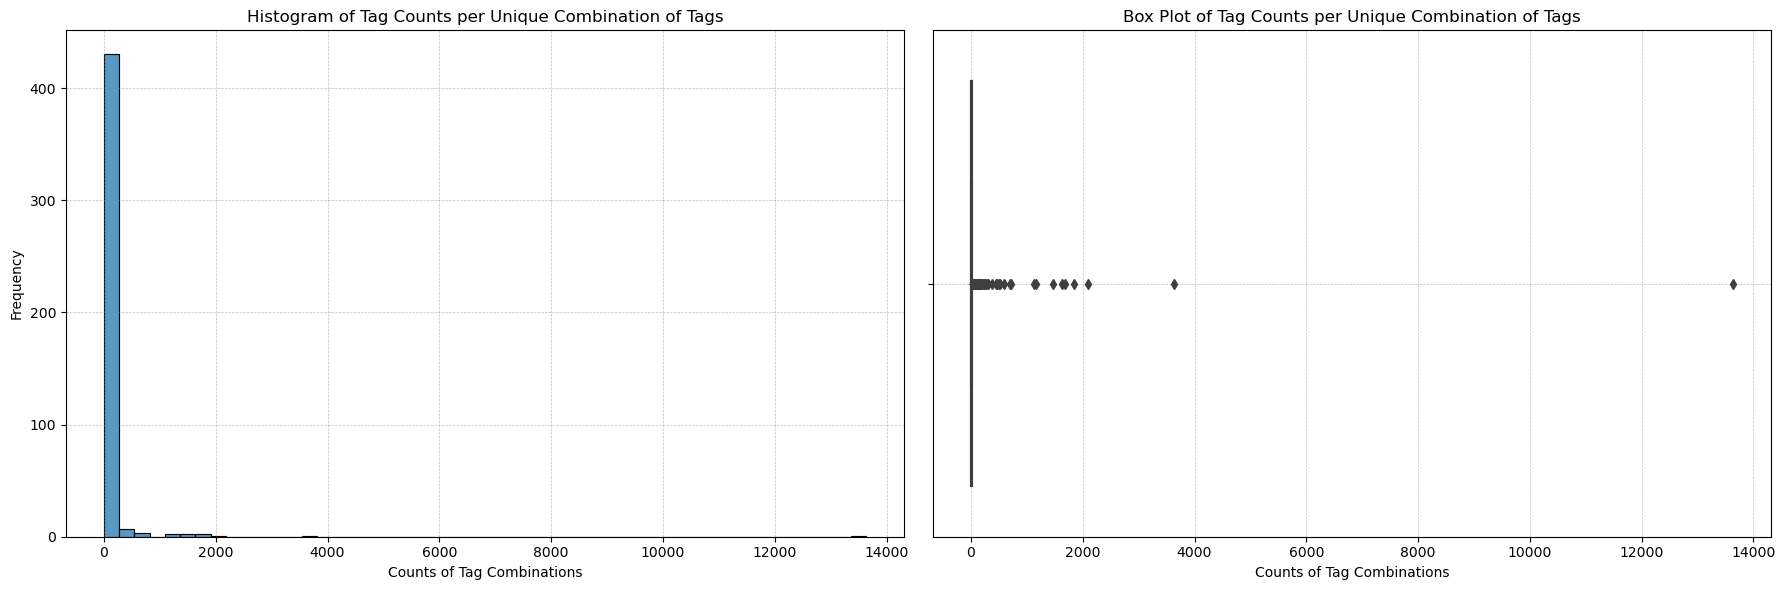

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Histogram of the tag counts
sns.histplot(tag_counts, bins=50, kde=False, ax=axes[0])
axes[0].set_title('Histogram of Tag Counts per Unique Combination of Tags')
axes[0].set_xlabel('Counts of Tag Combinations')
axes[0].set_ylabel('Frequency')
axes[0].grid(axis='y', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
axes[0].grid(axis='x', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)

# Boxplot of the tag counts
sns.boxplot(x=tag_counts, ax=axes[1])
axes[1].set_title('Box Plot of Tag Counts per Unique Combination of Tags')
axes[1].set_xlabel('Counts of Tag Combinations')
axes[1].grid(axis='y', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
axes[1].grid(axis='x', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)

plt.tight_layout()
plt.show()

The histogram on the left shows the frequency of the number of occurrences for each unique combination of tags. Since most tag combinations occur infrequently (as indicated by the peak at the left side of the histogram), the data is highly skewed with a long tail to the right. This long tail represents the few tag combinations that occur very often, which are the outliers in this distribution.

The box plot on the right shows the same distribution with a focus on the quartiles and outliers. The few tag combinations with very high counts likely represent common features or conditions and are outliers compared to the rest.

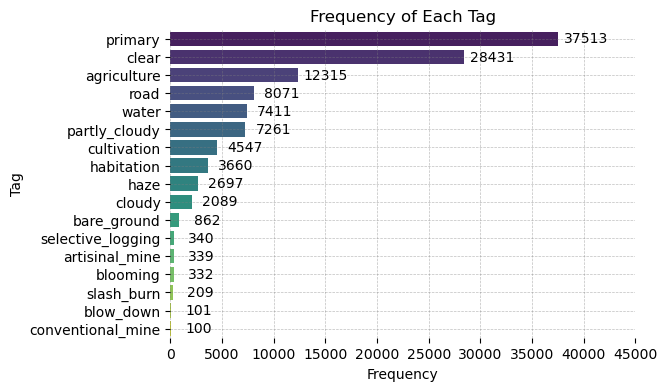

In [11]:
# Splitting tags
all_tags = [tag for sublist in train_labels['tags'].str.split() for tag in sublist]
tag_counts = Counter(all_tags)
tags_df = pd.DataFrame(tag_counts.items(), columns=['Tag', 'Count']).sort_values(by='Count', ascending=False)

# Barplot with the number for each bar plotted after the bar
plt.figure(figsize=(6,4 ))
barplot = sns.barplot(x='Count', y='Tag', data=tags_df, palette='viridis')
plt.title('Frequency of Each Tag')
plt.xlabel('Frequency')
plt.ylabel('Tag')
plt.grid(axis='y', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
plt.grid(axis='x', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
plt.xlim(0, 45000)
plt.box(False)

for p in barplot.patches:
    barplot.annotate(format(p.get_width(), '.0f'), 
                     (p.get_width(), p.get_y() + p.get_height() / 2.), 
                     ha = 'center', va = 'center', 
                     xytext = (20, 0), 
                     textcoords = 'offset points')

plt.show()

The most common tag is primary, present in 37,513 images, followed by clear, agriculture, road, and water. These tags likely represent the most prevalent features or conditions within the images.

---

## Correlation Analysis

In [12]:
train_labels['tags_list'] = train_labels['tags'].str.split()

mlb = MultiLabelBinarizer()
one_hot_encoded_tags = mlb.fit_transform(train_labels['tags_list'])
one_hot_encoded_df = pd.DataFrame(one_hot_encoded_tags, columns=mlb.classes_)
correlation_matrix = one_hot_encoded_df.corr()

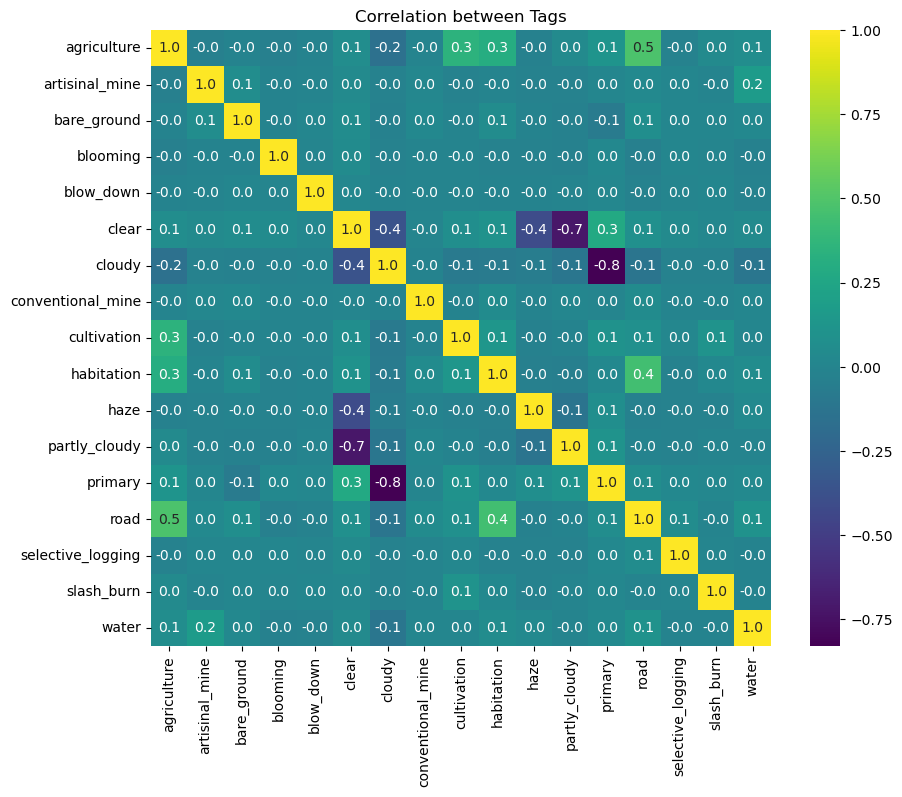

In [13]:
# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='viridis',annot=True, fmt=".1f")
plt.title('Correlation between Tags')
plt.show()

The correlation heatmap displays how tags are related to each other. For example, some tags such as 'primary' and 'cloudy' frequently occur together, suggesting a relationship between the features they represent.

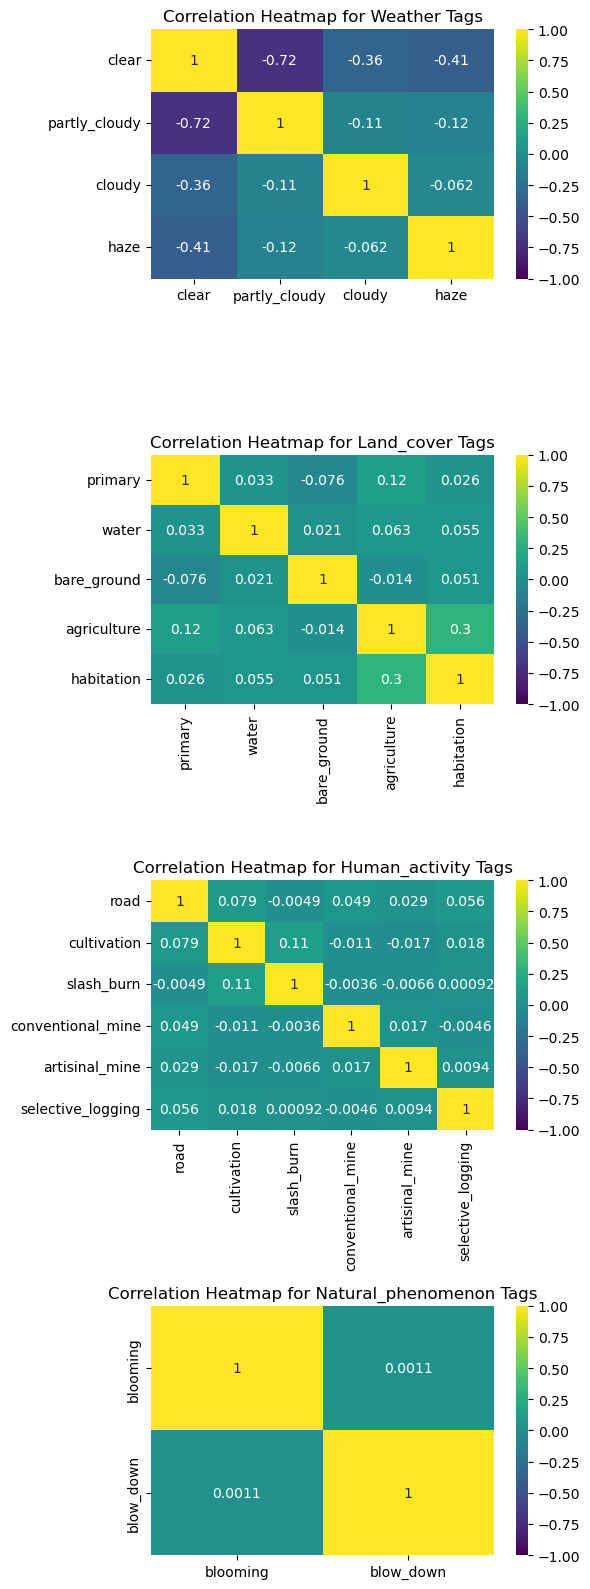

In [14]:
tag_categories = {
    'weather': ['clear', 'partly_cloudy', 'cloudy', 'haze'],
    'land_cover': ['primary', 'water', 'bare_ground', 'agriculture', 'habitation'],
    'human_activity': ['road', 'cultivation', 'slash_burn', 'conventional_mine', 'artisinal_mine', 'selective_logging'],
    'natural_phenomenon': ['blooming', 'blow_down']
}

# Recalculate the correlation matrix using the correct one-hot encoded data
correlation_matrix = one_hot_encoded_df.corr()

# Dictionary to hold the filtered correlation matrices for each tag category
filtered_correlation_matrices = {}

# Calculate the correlation matrix for each category
for category, tags_list in tag_categories.items():
    # Filter the correlation matrix for the tags in the current category
    filtered_correlation_matrix = correlation_matrix.loc[tags_list, tags_list]
    filtered_correlation_matrices[category] = filtered_correlation_matrix

# Plotting
fig, axes = plt.subplots(nrows=len(tag_categories), figsize=(6, 4 * len(tag_categories)))

# In case of a single category, ensure axes is iterable
if not isinstance(axes, np.ndarray):
    axes = [axes]

for ax, (category, matrix) in zip(axes, filtered_correlation_matrices.items()):
    sns.heatmap(matrix, annot=True, cmap='viridis', ax=ax, vmin=-1, vmax=1)
    ax.set_title(f'Correlation Heatmap for {category.capitalize()} Tags')

plt.tight_layout()
plt.show()

Based on the co-occurrence matrix for each category:

* **Wheather Tags** describe the atmospheric conditions captured in the images. A strong negative correlation exists between 'clear' and 'partially_cloudy', as well as between 'haze' and 'clear'. This suggests that these tags do not typically appear together in the images. Furthermore, it appears that each image is associated with a single weather label.

* **Land Cover Tags** encompass tags related to the type of land cover, including water bodies and vegetation, as well as human-altered landscapes like agricultural areas and habitations. There is no clear linear relationship in the occurrence of these tags. The highest correlation coefficient observed is 0.3, which is between 'agriculture' and 'habitation'. However, this correlation is not particularly strong, suggesting that only a few images depict settled farmlands.

* **Human Activity Tags** are associated with various human activities and their impact on the landscape, such as roads, agricultural cultivation, and slash-and-burn practices. The correlation values are close to zero, indicating no significant linear relationship in the occurrence of these tags.

* **Natural Phenomenon Tags** represent natural phenomena. These tags exhibit the lowest correlation values among all the categories, suggesting no discernible linear relationship in their occurrence. This lack of correlation is expected due to the random nature of such phenomena.

---

## Image check

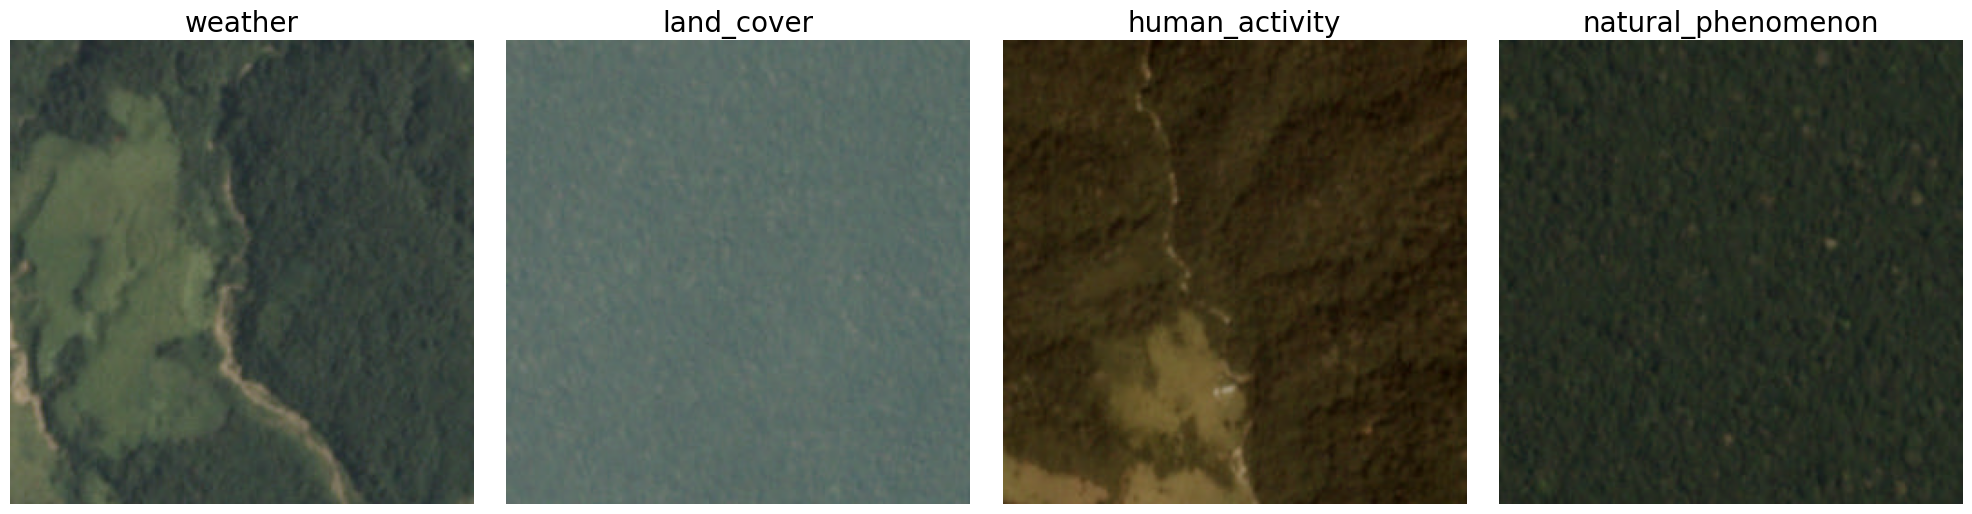

In [15]:
## Aproach 1: checking the general categories

image_dir = '/Users/daiannestarr/Desktop/Springboard/Capstone3/kaggle/planet/planet/train-jpg'

example_images = {}

for category, tags_list in tag_categories.items():
    for tag in tags_list:
        matching_images = train_labels[train_labels['tags'].str.contains(tag)]
        if not matching_images.empty:
            image_name = matching_images.iloc[0]['image_name']
            example_images[category] = os.path.join(image_dir, image_name + '.jpg')
            break

num_images = len(example_images)
plt.figure(figsize=(num_images * 5, 5))
for i, (category, image_path) in enumerate(example_images.items(), 1):
    img = mpimg.imread(image_path)
    plt.subplot(1, num_images, i)
    plt.imshow(img)
    plt.title(category, fontsize=20) 
    plt.axis('off')
plt.tight_layout()
plt.show()

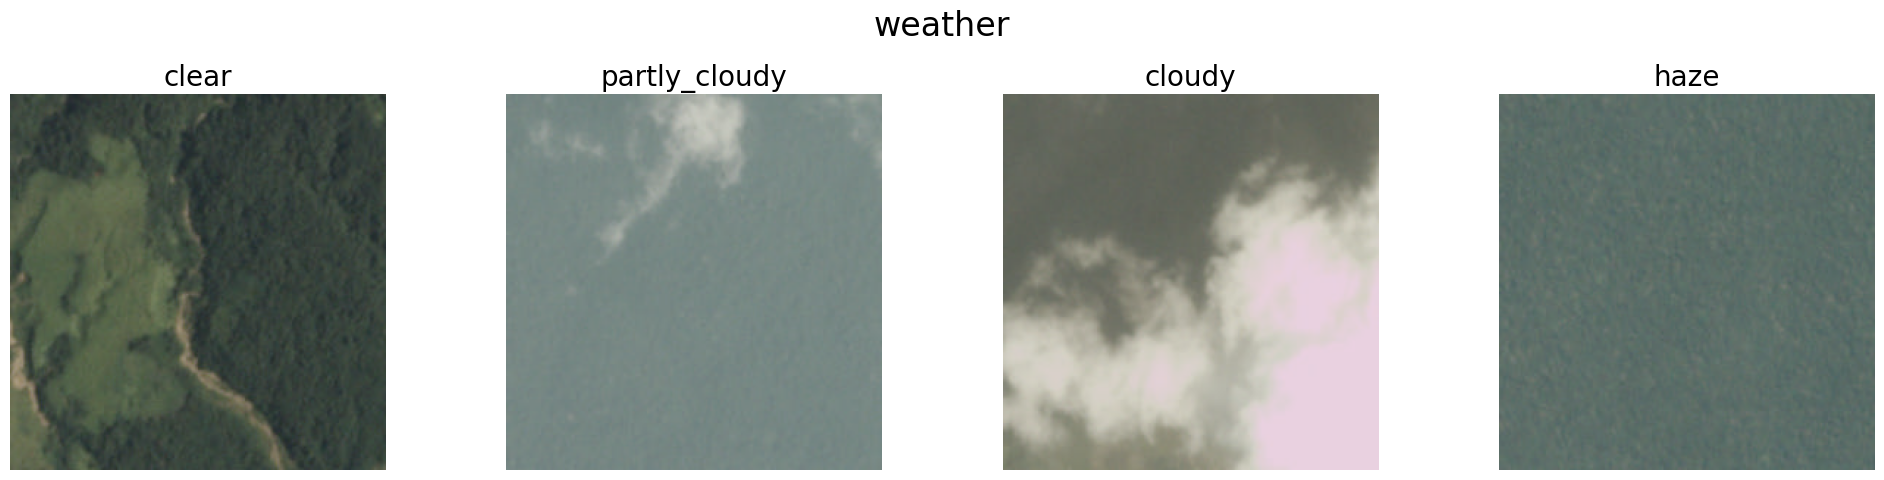

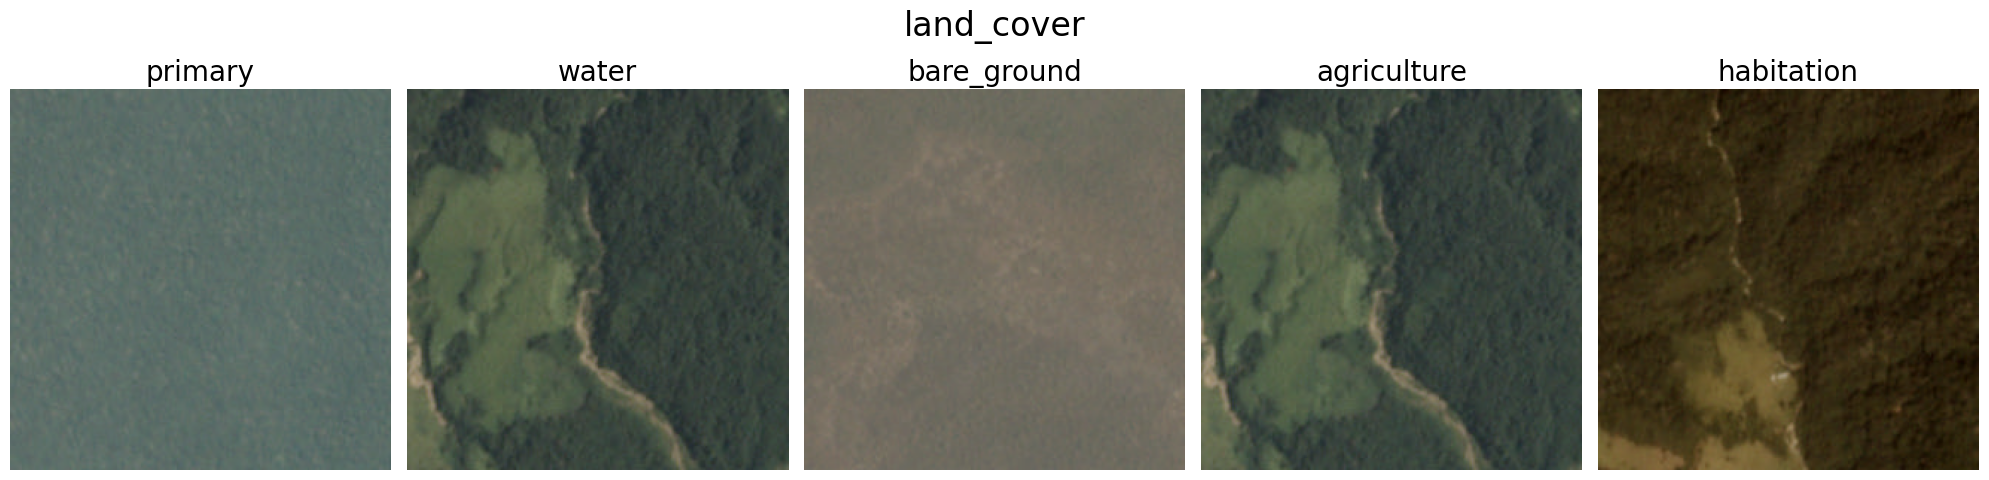

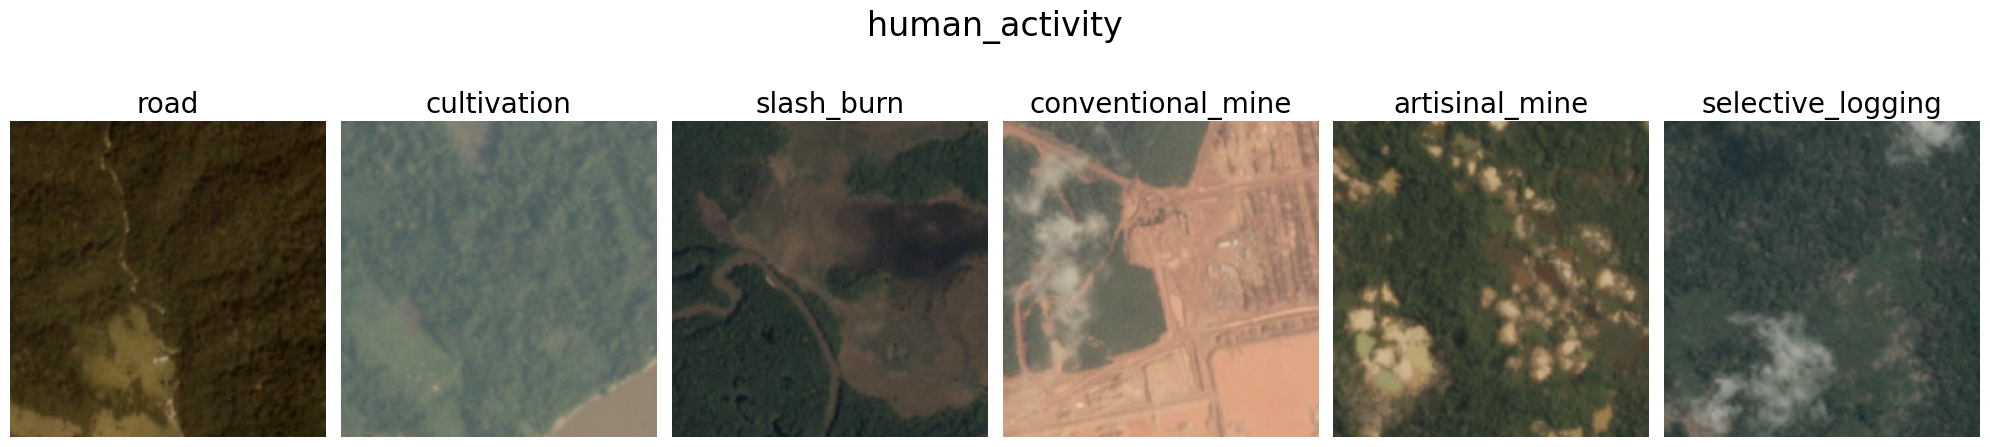

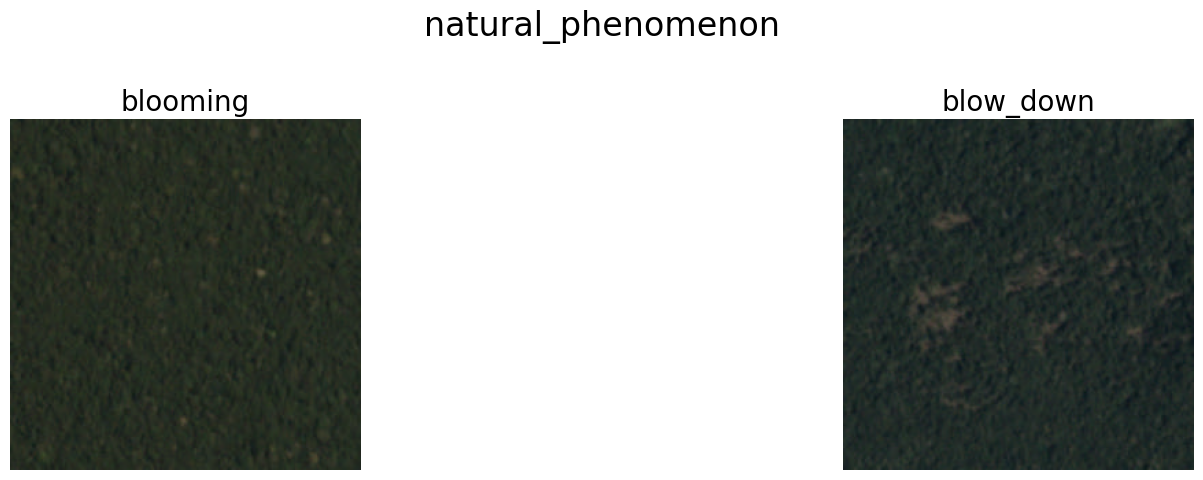

In [16]:
## Aproach 12: checking the elements inside of the general categories

def get_image_path(tag):
    matching_images = train_labels[train_labels['tags'].str.contains(tag)]
    if not matching_images.empty:
        return os.path.join(image_dir, matching_images.iloc[0]['image_name'] + '.jpg')
    return None

example_images = {category: {} for category in tag_categories}

for category, tags_list in tag_categories.items():
    for tag in tags_list:
        image_path = get_image_path(tag)
        if image_path:
            example_images[category][tag] = image_path

for category, tags in example_images.items():
    plt.figure(figsize=(20, 5)) 
    plt.suptitle(category, fontsize=24)
    for i, (tag, image_path) in enumerate(tags.items(), 1):
        plt.subplot(1, len(tags), i)
        img = mpimg.imread(image_path)
        plt.imshow(img)
        plt.title(tag, fontsize=20)
        plt.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
    plt.show()

For both approaches, the tags are representative of the images they are displaying.